## Deep learning & Art: Neural Style Transfer

- in this algorithm we optimize cost function to get a **pixel values** unlike the set of parameters.

Source: [Neural Style Transfer](https://arxiv.org/pdf/1508.06576)

In [1]:
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import pprint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from nst_utils import *

%matplotlib inline

### 1. Problem Statement:

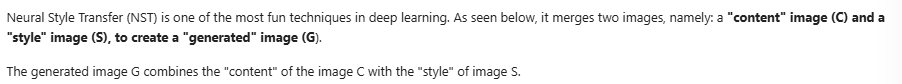


### 2. Transfer Learning

- we will use the VGG-19 model, a 19 layer version of VGG network to apply the concept of transfer learning and will apply on this problem/task.

In [2]:
def load_vgg_model(input_shape=(224, 224, 3), freeze_layers=True):
    """
    Loads VGG19 pretrained on ImageNet without the fully connected layers.
    Optionally freezes convolution layers for feature extraction.
    """

    # Load pretrained backbone
    vgg = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    if freeze_layers:
        for layer in vgg.layers:
            layer.trainable = False

    # Optional: Normalize input to match VGG19 preprocessing
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.vgg19.preprocess_input(inputs)

    # Forward through feature extractor
    outputs = vgg(x)

    # Build final model
    model = tf.keras.Model(inputs, outputs, name="VGG19_FeatureExtractor")

    return model


In [3]:
model = load_vgg_model()

In [4]:
model.summary()


Model: "VGG19_FeatureExtractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 7, 7, 512) │ 20,024,384 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

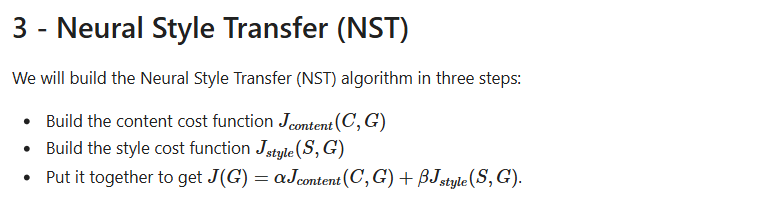

#### 3.1 Computing the Content cost


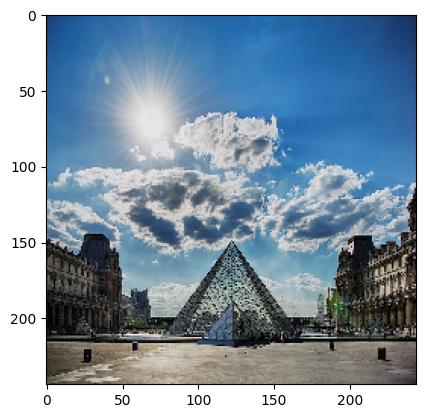

In [5]:
content_img = load_img("louvre.jpg", target_size=(244, 244))
# content_img = img_to_array(content_img)
# imshow(content_img.astype('uint8'))
imshow(content_img)

#### 3.1 make generated image G match the content of image c

- for this we will choose middle activation layer that would be apt for this, 
- Forward propagate the image C and then the image G
- Content Cost Function J (C, G)

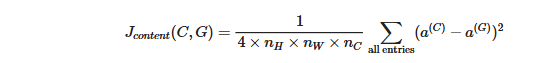


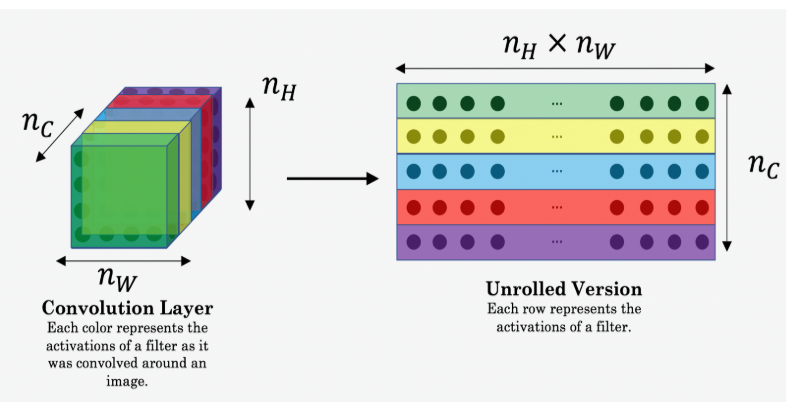



In [6]:
def compute_content_cost(a_C, a_G):

    m, n_h, n_w, n_c = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_h * n_w, n_c])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_h * n_w, n_c])
    J_content = (1/(4 * n_h * n_w * n_c)) * (tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))))

    return J_content


In [7]:
with tf.compat.v1.Session() as test:
    a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))



J_content = 8.505592


#### 3.2 Computing the style cost

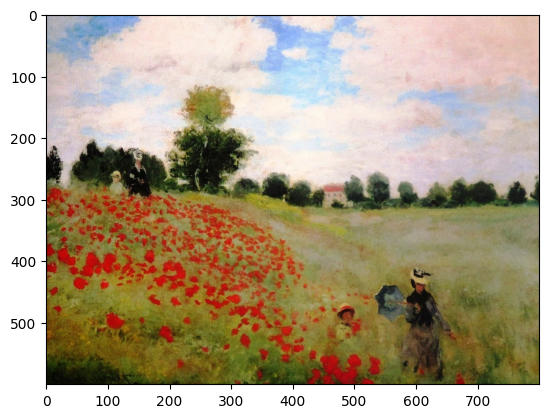

In [8]:
style_img = load_img("monet_800600.jpg")
imshow(style_img)

#### 3.2.1 Syle Matrix
 - style matrix also called **Gram matrix**

 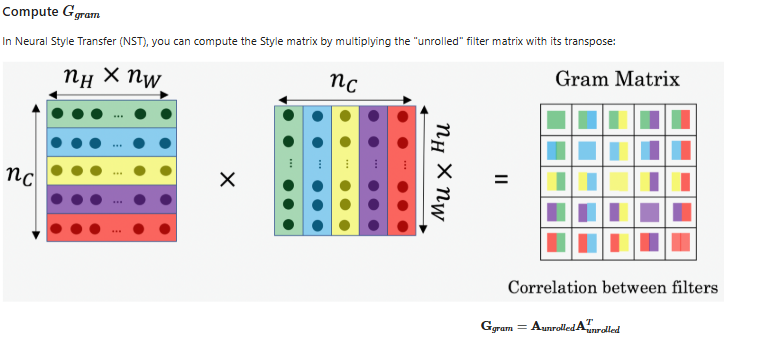

 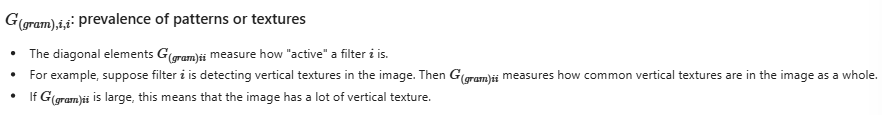
 


In [9]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [10]:
with tf.compat.v1.Session() as test:
    A = tf.random.normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    print("GA = " + str(GA.eval()))

GA = [[ 21.537575  26.984386  49.182423]
 [ 26.984386  34.000546  61.050247]
 [ 49.182423  61.050247 114.00642 ]]


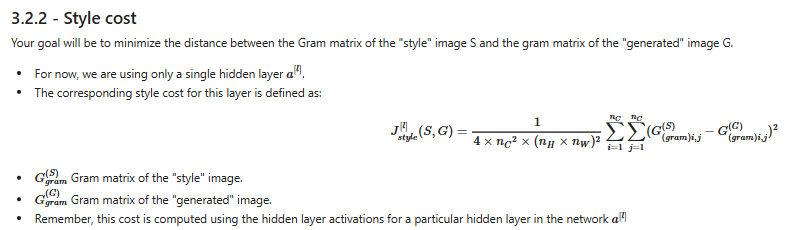

In [29]:
def compute_layer_style_cost(a_S, a_G):
    """
    Computes the style cost for a single layer.
    
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), style image's activations
    a_G -- tensor of dimension (1, n_H, n_W, n_C), generated image's activations
    
    Returns:
    J_style_layer -- tensor representing the style cost for the layer
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the tensors to have them of shape (n_C, n_H*n_W)
    a_S_unrolled = tf.reshape(a_S, shape=[n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[n_H * n_W, n_C])

    # Compute gram matrices for both images
    GS = gram_matrix(tf.transpose(a_S_unrolled))
    GG = gram_matrix(tf.transpose(a_G_unrolled))

    # Compute the style cost
    J_style_layer = (1 / (4 * (n_C ** 2) * (n_H * n_W) ** 2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    return J_style_layer

In [30]:
with tf.compat.v1.Session() as test:
    np.random.seed(1)
    a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    print("GA = " + str(J_style_layer.eval()))

GA = 4.4418845


#### 3.2.3 Style Weights

- each layer be given weights that reflect how much each layer will contribute to the style.

- as of now each layer is given 0.2 and summing upto 1 as total weights sum.

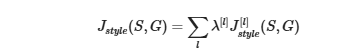

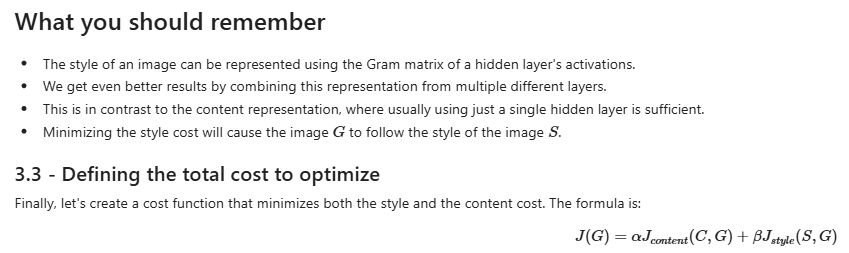

In [32]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

In [33]:
with tf.compat.v1.Session() as test:
    np.random.seed(1)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = -8.226802909370598


- total cost is a linear combination of both J-content and J-style and hyperparameters control the relative weighting between content and style.

#### 4. Optimizing the problem and assembling it together.

In [43]:
# content image
content_image = np.array(Image.open("images\louvre_small.jpg"))
content_image = reshape_and_normalize_image(content_image)

In [44]:
# style image
style_image = np.array(Image.open("monet_800600.jpg"))
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-61.455139038085946..71.63183846893311].


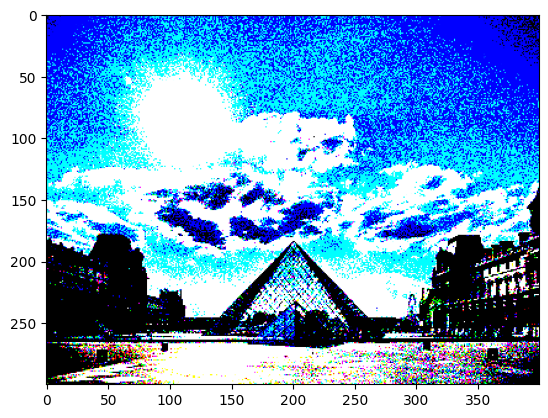

In [45]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

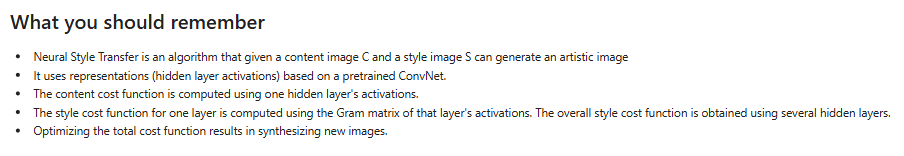

[Some things](https://arxiv.org/pdf/1409.1556)
[to read](https://harishnarayanan.org/writing/artistic-style-transfer/)
